# Notebook 00: Specialty Taxonomy with Anchored Similarity

## 🎯 Goals
- Collapse 5,126 raw `focus_area` strings into a manageable set of medical specialties.
- Apply reproducible, medically-aware rules so common conditions no longer fall into "rare disease" buckets.
- Export artifacts consumed by downstream notebooks (mapping, labeled dataset, metadata).

> 🔄 **Update note:** This notebook replaces the earlier pure clustering approach that misrouted terms like "Breast Cancer" or "Cholera." We now blend TF-IDF anchor similarity with rule-based overrides and explicit quality checks.


## 🔧 Setup

Import dependencies, configure project paths, and create the taxonomy artifact folder.


In [1]:
# Project paths and shared imports
from pathlib import Path
import json
import re
import string
import unicodedata
from collections import Counter
from datetime import datetime

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

# Configure paths
DATA_DIR = Path("../../../datasets")
INPUT_PATH = DATA_DIR / "medquad.csv"
ARTIFACTS_DIR = Path("../artifacts/specialty_taxonomy")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ Input data: {INPUT_PATH}")
print(f"✅ Artifacts directory: {ARTIFACTS_DIR}")

# Text normalization helper used throughout the notebook
PUNCT_TRANSLATOR = str.maketrans({c: " " for c in string.punctuation})

def normalize_for_matching(text: str) -> str:
    'Lowercase + strip accents + collapse whitespace for rule matching.'
    text = (text or "").strip().lower()
    text = unicodedata.normalize("NFKD", text)
    text = "".join(ch for ch in text if not unicodedata.combining(ch))
    text = text.translate(PUNCT_TRANSLATOR)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

np.random.seed(42)


✅ Input data: ../../../datasets/medquad.csv
✅ Artifacts directory: ../artifacts/specialty_taxonomy


## 📥 Load MedQuad Q&A

Read the dataset, sanity-check required columns, and create normalized focus area columns.


In [2]:
# Load MedQuad dataset and basic sanity checks
df = pd.read_csv(INPUT_PATH)

expected_cols = {"focus_area", "question", "answer"}
missing = expected_cols.difference(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Drop rows without focus_area and create normalized variants
df = df.dropna(subset=["focus_area"]).copy()
df["focus_area"] = df["focus_area"].astype(str)
df["focus_area_norm"] = df["focus_area"].str.strip().str.lower()
df["focus_area_simple"] = df["focus_area"].apply(normalize_for_matching)

print(f"Rows loaded: {len(df):,}")
print(f"Unique focus_area strings: {df['focus_area_norm'].nunique():,}")

display(df.head())


Rows loaded: 16,398
Unique focus_area strings: 4,742


,question,answer,source,focus_area,focus_area_norm,focus_area_simple
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,glaucoma,glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma,glaucoma,glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma,glaucoma,glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma,glaucoma,glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,glaucoma,glaucoma


## 🗂️ Build Focus Area Catalog

Deduplicate `focus_area` strings, track how often they appear, and normalize them for text matching.


In [3]:
# Build catalog of unique focus_area entries
catalog_df = (
    df.groupby(["focus_area_norm", "focus_area_simple"], as_index=False)
      .agg(
          sample_count=("focus_area", "size"),
          focus_area_display=("focus_area", "first")
      )
      .sort_values("sample_count", ascending=False)
      .reset_index(drop=True)
)

print(f"Catalog size: {len(catalog_df):,} focus_area terms")
display(catalog_df.head(10))


Catalog size: 4,742 focus_area terms


,focus_area_norm,focus_area_simple,sample_count,focus_area_display
0,breast cancer,breast cancer,58,Breast Cancer
1,prostate cancer,prostate cancer,48,Prostate Cancer
2,stroke,stroke,35,Stroke
3,lung cancer,lung cancer,34,Lung Cancer
4,skin cancer,skin cancer,34,Skin Cancer
5,alzheimer's disease,alzheimer s disease,30,Alzheimer's Disease
6,colorectal cancer,colorectal cancer,29,Colorectal Cancer
7,causes of diabetes,causes of diabetes,28,Causes of Diabetes
8,heart failure,heart failure,28,Heart Failure
9,heart attack,heart attack,28,Heart Attack


## 🧭 Define Specialty Anchors & Rules

We craft a curated taxonomy made of 20 clinical specialties. Each specialty has:
- **Anchor phrases** describing its scope (for TF-IDF cosine similarity).
- **Keyword boosts** that nudge high-signal terms (e.g., `cancer`, `glaucoma`).
- **Override patterns** for unmistakable matches (e.g., any `breast cancer` → Oncology).
- **Fallback rules** so low-confidence terms still land in a sensible bucket.


In [4]:
SPECIALTY_ANCHORS = {
    "Oncology": [
        "medical oncology cancer tumor treatment",
        "chemotherapy and radiation for metastatic cancer",
        "hematologic malignancies leukemia lymphoma oncology",
        "solid tumor oncology breast lung prostate colorectal",
        "melanoma sarcoma rare cancer care"
    ],
    "Infectious Diseases": [
        "infectious disease bacterial viral parasitic infections",
        "antibiotics antivirals antifungals for infections",
        "epidemic diseases cholera malaria tuberculosis",
        "vaccination prevention outbreak control",
        "emerging infectious diseases outbreak management"
    ],
    "Cardiology & Vascular": [
        "cardiology heart disease hypertension arrhythmia",
        "coronary artery disease myocardial infarction",
        "cardiac electrophysiology long qt atrial fibrillation",
        "heart failure cardiomyopathy vascular management",
        "hyperlipidemia prevention cardiovascular risk"
    ],
    "Neurology & Neurosurgery": [
        "neurology brain disorders epilepsy stroke",
        "neurodegenerative diseases parkinson alzheimer",
        "neuromuscular disease neuropathy myopathy",
        "movement disorders deep brain stimulation",
        "neurosurgery for brain and spine conditions"
    ],
    "Endocrinology & Diabetes": [
        "endocrinology hormone disorders thyroid adrenal",
        "diabetes mellitus insulin glycemic control",
        "metabolic syndrome obesity lipid disorders",
        "endocrine tumors pituitary parathyroid pancreas",
        "reproductive endocrinology menstrual hormone care"
    ],
    "Gastroenterology & Hepatology": [
        "gastroenterology digestive stomach intestine colon",
        "hepatology liver disease hepatitis cirrhosis",
        "inflammatory bowel disease crohn ulcerative colitis",
        "pancreatitis biliary tract gallbladder disorders",
        "nutrition malabsorption celiac disease"
    ],
    "Nephrology & Urology": [
        "nephrology kidney disease chronic renal failure",
        "urology urinary tract bladder prostate disorders",
        "glomerulonephritis nephrotic syndrome nephropathy",
        "kidney stones renal colic prevention",
        "hypertension kidney transplant management"
    ],
    "Pulmonology & Respiratory": [
        "pulmonology lung disease asthma copd",
        "respiratory infections pneumonia bronchitis",
        "sleep apnea respiratory failure ventilation",
        "interstitial lung disease pulmonary fibrosis",
        "occupational lung disease smoking cessation"
    ],
    "Immunology & Rheumatology": [
        "rheumatology autoimmune disorders lupus",
        "immune deficiency hypersensitivity immunology",
        "vasculitis connective tissue disease",
        "inflammatory arthritis psoriatic ankylosing",
        "biologic therapy autoimmune management"
    ],
    "Hematology": [
        "hematology blood disorders anemia hemophilia",
        "coagulation thrombosis bleeding disorders",
        "myeloproliferative neoplasm polycythemia vera",
        "bone marrow failure aplastic anemia",
        "transfusion medicine hematologic diagnostics"
    ],
    "Dermatology": [
        "dermatology skin disease eczema psoriasis acne",
        "hair nail disorders alopecia dermatology",
        "autoimmune skin disease pemphigus lupus",
        "skin infections bacterial fungal viral",
        "photodermatology sun damage melanoma prevention"
    ],
    "Ophthalmology": [
        "ophthalmology eye disease glaucoma cataract",
        "retina disorders macular degeneration",
        "neuro ophthalmology optic nerve disorders",
        "pediatric ophthalmology strabismus amblyopia",
        "cornea external eye disease keratitis"
    ],
    "Otolaryngology & ENT": [
        "otolaryngology ear nose throat sinus disease",
        "hearing loss otitis media audiology",
        "sinusitis allergic rhinitis nasal polyps",
        "laryngology voice airway disorders",
        "sleep apnea snoring airway obstruction ent"
    ],
    "Dental & Oral Health": [
        "dentistry oral health periodontal disease",
        "tooth decay dental caries prevention",
        "oral surgery wisdom teeth extraction",
        "orthodontics jaw alignment dental braces",
        "oral infections stomatitis gingivitis"
    ],
    "Obstetrics & Gynecology": [
        "obstetrics pregnancy prenatal care labor",
        "gynecology uterine ovarian cervical disorders",
        "reproductive health contraception fertility",
        "menopause hormone therapy women's health",
        "maternal fetal medicine high risk pregnancy"
    ],
    "Pediatrics & Development": [
        "pediatrics child health immunizations development",
        "neonatology newborn care premature infants",
        "pediatric infectious diseases childhood illnesses",
        "pediatric neurology developmental disorders",
        "adolescent medicine growth puberty"
    ],
    "Psychiatry & Behavioral Health": [
        "psychiatry mental health depression anxiety",
        "behavioral health substance use addiction",
        "psychotherapy cognitive behavioral therapy",
        "neurodevelopmental disorders autism adhd",
        "psychosis schizophrenia psychiatric emergencies"
    ],
    "Musculoskeletal & Orthopedics": [
        "orthopedics bone fracture joint replacement",
        "sports medicine ligament tendon injury",
        "musculoskeletal pain management back pain",
        "osteoporosis metabolic bone disease",
        "rehabilitation physical therapy orthopedics"
    ],
    "Genetics & Rare Disorders": [
        "medical genetics rare inherited diseases",
        "genomic medicine chromosomal abnormalities",
        "metabolic disorders lysosomal storage diseases",
        "genetic counseling prenatal diagnosis",
        "rare disease registry orphan conditions"
    ],
    "General & Preventive Medicine": [
        "primary care general internal medicine prevention",
        "health maintenance wellness screening counseling",
        "geriatrics chronic disease management",
        "population health lifestyle medicine",
        "nutrition counseling preventive medicine"
    ]
}

SPECIALTY_ORDER = list(SPECIALTY_ANCHORS.keys())

KEYWORD_PATTERNS_RAW = {
    "Oncology": [
        (r"\bcancer\b", 0.35),
        (r"\btumou?r\b", 0.25),
        (r"\bcarcinoma\b", 0.30),
        (r"\bsarcoma\b", 0.30),
        (r"\b(leukemia|lymphoma|myeloma|blastoma)\b", 0.30),
        (r"oncolog", 0.20),
        (r"\bcarcinoid\b", 0.30)
    ],
    "Infectious Diseases": [
        (r"\bvirus|viral|retrovirus\b", 0.25),
        (r"\b(bacteria|bacterial|fungal|parasit)\b", 0.25),
        (r"\binfection\b", 0.20),
        (r"\b(hiv|aids|hepatitis|influenza|covid|ebola|cholera|tuberculosis|malaria)\b", 0.35),
        (r"\bvaccine|vaccination|immunization\b", 0.20)
    ],
    "Cardiology & Vascular": [
        (r"\bcardio", 0.30),
        (r"\bheart\b", 0.35),
        (r"\b(coronary|artery|aortic|atrial|ventricular)\b", 0.25),
        (r"\b(arrhythmia|tachycardia|bradycardia|qt)\b", 0.30),
        (r"\b(hypertension|blood pressure|hyperlipidemia)\b", 0.25)
    ],
    "Neurology & Neurosurgery": [
        (r"\bneuro", 0.30),
        (r"\bbrain\b", 0.30),
        (r"\b(stroke|seizure|epilepsy|migraine|headache)\b", 0.30),
        (r"\b(parkinson|alzheimer|dementia|neuropathy|myopathy|multiple sclerosis)\b", 0.30),
        (r"deep brain stimulation", 0.40),
        (r"kluver", 0.40)
    ],
    "Endocrinology & Diabetes": [
        (r"\bdiabet", 0.40),
        (r"\binsulin\b", 0.30),
        (r"\b(endocrin|hormone|thyroid|pituitary|adrenal|parathyroid)\b", 0.30),
        (r"\bmetabolic\b", 0.20),
        (r"\bobesit|glycem", 0.20)
    ],
    "Gastroenterology & Hepatology": [
        (r"\b(gastr|stomach|intestinal|colon|bowel|rectal)\b", 0.30),
        (r"\b(hepati|liver|biliary|gallbladder|pancrea)\b", 0.30),
        (r"\b(celiac|crohn|ulcerative colitis|ibd)\b", 0.30),
        (r"\b(ibs|reflux|gerd)\b", 0.20)
    ],
    "Nephrology & Urology": [
        (r"\b(kidney|renal|nephro)\b", 0.40),
        (r"\b(urinary|urolog|bladder|prostat)\b", 0.30),
        (r"\bdialysis\b", 0.30),
        (r"\bstone\b", 0.20)
    ],
    "Pulmonology & Respiratory": [
        (r"\b(lung|pulmon)\b", 0.35),
        (r"\b(asthma|bronch|copd|pneum|respirat)\b", 0.30),
        (r"sleep apnea", 0.30),
        (r"\bfibrosis\b", 0.20)
    ],
    "Immunology & Rheumatology": [
        (r"\b(autoimmune|immune)\b", 0.30),
        (r"\brheumat", 0.30),
        (r"\b(arthritis|lupus|sjogren|scleroderma|vasculitis)\b", 0.30),
        (r"\b(immunodefic|immunolog)\b", 0.25)
    ],
    "Hematology": [
        (r"\b(anemia|hemoglobin|hematolog)\b", 0.30),
        (r"\b(hemophilia|thrombo|coagul|platelet|blood)\b", 0.30),
        (r"\bpolycythemia\b", 0.30),
        (r"\bsickle\b", 0.30)
    ],
    "Dermatology": [
        (r"\bskin\b", 0.25),
        (r"\bdermat", 0.35),
        (r"\b(psoriasis|eczema|alopecia|pityriasis|acne|urticaria)\b", 0.35),
        (r"\brash\b", 0.20)
    ],
    "Ophthalmology": [
        (r"\b(eye|ocular|vision)\b", 0.35),
        (r"\bophthalm", 0.35),
        (r"\b(glaucoma|cataract|retina|macula|optic)\b", 0.35)
    ],
    "Otolaryngology & ENT": [
        (r"\b(ear|nose|throat|sinus|tonsil|laryng|rhinitis|otitis)\b", 0.35),
        (r"\bhearing\b", 0.30),
        (r"\bENT\b", 0.20)
    ],
    "Dental & Oral Health": [
        (r"\b(dent|tooth|teeth|oral|gum|periodont|cavity|mouth)\b", 0.35)
    ],
    "Obstetrics & Gynecology": [
        (r"\b(pregnan|obstetric|prenatal|maternal|fetal)\b", 0.35),
        (r"\b(gyneco|uterin|ovarian|cervic|fallopian)\b", 0.35),
        (r"\b(endometri|menopause|menstrual|fertility)\b", 0.30)
    ],
    "Pediatrics & Development": [
        (r"\b(child|pediatric|infant|newborn|neonat|toddler|adolescent)\b", 0.35),
        (r"\bgrowth\b", 0.20),
        (r"\bdevelopment\b", 0.20)
    ],
    "Psychiatry & Behavioral Health": [
        (r"\b(mental|psychi|psych)\b", 0.35),
        (r"\b(depression|anxiety|bipolar|schizo|psychosis)\b", 0.35),
        (r"\b(autism|adhd|behavior|addiction|substance)\b", 0.30)
    ],
    "Musculoskeletal & Orthopedics": [
        (r"\b(bone|joint|spine|orthop|scoliosis)\b", 0.30),
        (r"\b(muscle|tendon|ligament)\b", 0.30),
        (r"\b(fracture|sprain|strain|back pain|osteo)\b", 0.30)
    ],
    "Genetics & Rare Disorders": [
        (r"\b(syndrome|genetic|mutation|chromosome|inherited|hereditary|x linked|autosomal|rare disease)\b", 0.40)
    ],
    "General & Preventive Medicine": [
        (r"\b(general practice|primary care|preventive|screening|checkup|wellness)\b", 0.30),
        (r"\b(health maintenance|lifestyle|nutrition|counseling)\b", 0.20)
    ]
}

OVERRIDE_RULES_RAW = [
    (r"\b(cancer|carcinoma|sarcoma|tumou?r|leukemia|lymphoma|melanoma|myeloma|neoplasm|blastoma|carcinoid)\b", "Oncology"),
    (r"\b(cholera|tuberculosis|tb|malaria|dengue|ebola|zika|influenza|flu|measles|mumps|rubella|pertussis|hepatitis|hiv|aids|norovirus|rotavirus|typhoid|plague|leprosy|polio|smallpox)\b", "Infectious Diseases"),
    (r"\b(cardiac|cardio|heart|coronary|artery|aortic|atrial|ventricular|qt|arrhythm|tachycardia|bradycardia|myocard|angina|cardiomyopathy|hypertension|blood pressure|hyperlipidemia)\b", "Cardiology & Vascular"),
    (r"(deep brain stimulation|kluver|neurolog|brain|stroke|seizure|epilepsy|parkinson|alzheimer|dementia|neuropathy|myopathy|multiple sclerosis|spinal|spine|cerebral|encephal)", "Neurology & Neurosurgery"),
    (r"\b(diabet|insulin|endocrin|thyroid|hormone|pituitary|adrenal|parathyroid|metabolic|glycem|obes)\b", "Endocrinology & Diabetes"),
    (r"\b(hepati|liver|cirrhosis|gastro|stomach|intestinal|colon|bowel|pancrea|crohn|ulcerative colitis|celiac|gallbladder|biliary)\b", "Gastroenterology & Hepatology"),
    (r"\b(kidney|renal|nephro|dialysis|urinary|urolog|bladder|prostat|ureter|glomerul)\b", "Nephrology & Urology"),
    (r"\b(lung|pulmon|asthma|bronch|respirat|copd|pneum|emphysema|bronchiol)\b", "Pulmonology & Respiratory"),
    (r"\b(autoimmune|immune|rheumat|arthritis|lupus|scleroderma|sjogren|vasculitis)\b", "Immunology & Rheumatology"),
    (r"\b(anemia|hemoglobin|hematolog|hemophilia|thrombo|coagul|platelet|polycythemia|sickle)\b", "Hematology"),
    (r"\b(dermat|skin|psoriasis|eczema|alopecia|pityriasis|urticaria|acne|dermato|melasma)\b", "Dermatology"),
    (r"\b(eye|ocular|ophthalm|glaucoma|cataract|retina|macula|vision|optic)\b", "Ophthalmology"),
    (r"\b(ear|otitis|hearing|tinnitus|sinus|rhinitis|tonsil|laryng|throat|ent|nasal)\b", "Otolaryngology & ENT"),
    (r"\b(dent|tooth|oral|gum|periodont|cavity|mouth)\b", "Dental & Oral Health"),
    (r"\b(pregnan|obstetric|gyneco|uterin|ovarian|cervic|menstru|menopause|fertility|endometri|preeclampsia)\b", "Obstetrics & Gynecology"),
    (r"\b(child|pediatric|infant|newborn|neonat|toddler|adolescent)\b", "Pediatrics & Development"),
    (r"\b(mental|psychi|depress|anxiety|bipolar|schizo|psychosis|autism|adhd|behavior|addiction|substance)\b", "Psychiatry & Behavioral Health"),
    (r"\b(bone|joint|muscle|orthop|ligament|tendon|fracture|scoliosis|osteoarthritis|osteoporosis|back pain|spine)\b", "Musculoskeletal & Orthopedics"),
    (r"\b(syndrome|genetic|mutation|chromosome|inherited|hereditary|x linked|autosomal|rare disease|dysplasia)\b", "Genetics & Rare Disorders")
]

FALLBACK_RULES_RAW = [
    (r"\b(syndrome|genetic|mutation|chromosome|inherited|hereditary|rare disease)\b", "Genetics & Rare Disorders"),
    (r"\b(rehabilitation|physiotherapy|mobility|gait|orthotic|prosthetic|amputation)\b", "Musculoskeletal & Orthopedics"),
    (r"\b(nutrition|diet|vitamin|supplement|obesity)\b", "General & Preventive Medicine"),
    (r"\b(vaccine|vaccination|immunization)\b", "Infectious Diseases")
]

KEYWORD_PATTERNS = {
    category: [(re.compile(pattern, flags=re.IGNORECASE), weight) for pattern, weight in patterns]
    for category, patterns in KEYWORD_PATTERNS_RAW.items()
}

OVERRIDE_RULES = [(re.compile(pattern, flags=re.IGNORECASE), category) for pattern, category in OVERRIDE_RULES_RAW]
FALLBACK_RULES = [(re.compile(pattern, flags=re.IGNORECASE), category) for pattern, category in FALLBACK_RULES_RAW]

LOW_CONFIDENCE_THRESHOLD = 0.18


## 🔢 Vectorize Anchors & Focus Areas

Fit a TF-IDF vectorizer on normalized focus area text plus the anchor phrases. Then compute cosine similarity between each focus area and every specialty centroid.


In [5]:
# Fit vectorizer on focus areas + anchor phrases
anchor_phrases = [phrase for phrases in SPECIALTY_ANCHORS.values() for phrase in phrases]
fit_corpus = catalog_df["focus_area_simple"].tolist() + anchor_phrases

vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1, 2), min_df=1)
vectorizer.fit(fit_corpus)

focus_matrix = vectorizer.transform(catalog_df["focus_area_simple"])
centroid_rows = []
for category in SPECIALTY_ORDER:
    phrase_matrix = vectorizer.transform(SPECIALTY_ANCHORS[category])
    centroid_rows.append(sparse.csr_matrix(phrase_matrix.mean(axis=0)))
centroid_matrix = sparse.vstack(centroid_rows)

base_similarity = cosine_similarity(focus_matrix, centroid_matrix)
print("Similarity matrix shape:", base_similarity.shape)


Similarity matrix shape: (4742, 20)


## 🧮 Score & Assign Specialties

Combine cosine similarity with keyword boosts. Apply override rules first, then fall back to similarity and low-confidence heuristics.


In [6]:
scores = np.array(base_similarity, dtype=np.float32)
simple_texts = catalog_df["focus_area_simple"].tolist()

# Apply keyword boosts
for idx, text in enumerate(simple_texts):
    for col_idx, category in enumerate(SPECIALTY_ORDER):
        for pattern, weight in KEYWORD_PATTERNS.get(category, []):
            if pattern.search(text):
                scores[idx, col_idx] += weight

sorted_indices = np.argsort(scores, axis=1)
top_indices = sorted_indices[:, -1]
second_indices = sorted_indices[:, -2]
top_scores = scores[np.arange(scores.shape[0]), top_indices]
second_scores = scores[np.arange(scores.shape[0]), second_indices]

assignments = []
sources = []
confidence = []
override_hits = 0
fallback_hits = 0

for idx, text in enumerate(simple_texts):
    assigned_category = None
    assigned_source = None
    assigned_score = None

    for pattern, category in OVERRIDE_RULES:
        if pattern.search(text):
            assigned_category = category
            assigned_source = "regex_override"
            assigned_score = 1.0
            override_hits += 1
            break

    if assigned_category is None:
        candidate_idx = int(top_indices[idx])
        candidate_category = SPECIALTY_ORDER[candidate_idx]
        candidate_score = float(scores[idx, candidate_idx])
        if candidate_score < LOW_CONFIDENCE_THRESHOLD:
            for pattern, category in FALLBACK_RULES:
                if pattern.search(text):
                    assigned_category = category
                    assigned_source = "fallback_pattern"
                    assigned_score = candidate_score
                    fallback_hits += 1
                    break
        if assigned_category is None:
            if candidate_score < LOW_CONFIDENCE_THRESHOLD:
                assigned_category = "General & Preventive Medicine"
                assigned_source = "fallback_default"
                assigned_score = candidate_score
                fallback_hits += 1
            else:
                assigned_category = candidate_category
                assigned_source = "anchor_similarity"
                assigned_score = candidate_score

    assignments.append(assigned_category)
    sources.append(assigned_source)
    confidence.append(assigned_score)

catalog_assignments = catalog_df.copy()
catalog_assignments["specialty"] = assignments
catalog_assignments["specialty_score"] = confidence
catalog_assignments["assignment_source"] = sources
catalog_assignments["runner_up"] = [SPECIALTY_ORDER[i] for i in second_indices]
catalog_assignments["runner_up_score"] = second_scores
catalog_assignments["score_margin"] = catalog_assignments["specialty_score"] - catalog_assignments["runner_up_score"]

print(f"✅ Assigned specialties: {catalog_assignments['specialty'].nunique()} categories")
print(f"   Override hits: {override_hits:,} | Fallback hits: {fallback_hits:,}")


✅ Assigned specialties: 20 categories
   Override hits: 2,270 | Fallback hits: 2,264


## ✅ Quality Checks

1. Assert that historically misclassified terms now map to the expected specialty.
2. Flag the most ambiguous assignments (small score margin) for manual review.


In [7]:
validation_cases = {
    "breast cancer": "Oncology",
    "cataract": "Ophthalmology",
    "cholera": "Infectious Diseases",
    "wilson-turner syndrome": "Genetics & Rare Disorders",
    "familial pityriasis rubra pilaris": "Dermatology",
    "deep brain stimulation": "Neurology & Neurosurgery",
    "kluver-bucy syndrome": "Neurology & Neurosurgery",
    "long qt syndrome": "Cardiology & Vascular",
    "diabetes eye problems": "Endocrinology & Diabetes"
}

failures = []
for term, expected in validation_cases.items():
    match = catalog_assignments.loc[catalog_assignments["focus_area_norm"] == term, "specialty"]
    if match.empty:
        failures.append((term, expected, "focus_area missing"))
    else:
        actual = match.iloc[0]
        if actual != expected:
            failures.append((term, expected, actual))

if failures:
    print("❌ Validation mismatches detected:")
    for term, expected, actual in failures:
        print(f"  - '{term}': expected {expected}, got {actual}")
    raise AssertionError("Targeted validation cases failed.")
else:
    print("✅ All targeted validation cases mapped to the expected specialties.")


❌ Validation mismatches detected:
  - 'deep brain stimulation': expected Neurology & Neurosurgery, got focus_area missing
  - 'kluver-bucy syndrome': expected Neurology & Neurosurgery, got focus_area missing
  - 'diabetes eye problems': expected Endocrinology & Diabetes, got focus_area missing


AssertionError: Targeted validation cases failed.

In [8]:
ambiguous = (
    catalog_assignments
    .sort_values("score_margin")
    .head(15)[["focus_area_display", "specialty", "specialty_score", "runner_up", "runner_up_score", "assignment_source"]]
)
print("🔍 Most ambiguous mappings (lowest score margins):")
display(ambiguous)

sample_view = (
    catalog_assignments
    .groupby("specialty", as_index=False)
    .head(3)[["specialty", "focus_area_display", "sample_count", "assignment_source"]]
    .reset_index(drop=True)
)
print("📋 Sample focus_areas per specialty:")
display(sample_view)


🔍 Most ambiguous mappings (lowest score margins):


,focus_area_display,specialty,specialty_score,runner_up,runner_up_score,assignment_source
2370,Sacrococcygeal Teratoma,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default
3462,Attention Deficit Hyperactivity Disorder,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default
3463,Stem Cells,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default
1595,mucolipidosis III gamma,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default
1582,potassium-aggravated myotonia,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default
3474,Athlete's Foot,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default
3476,Statins,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default
1575,Multifocal choroiditis,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default
3480,Gluten Sensitivity,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default
3481,Persistent genital arousal disorder,General & Preventive Medicine,0.0,Genetics & Rare Disorders,0.0,fallback_default


📋 Sample focus_areas per specialty:


,specialty,focus_area_display,sample_count,assignment_source
0,Oncology,Breast Cancer,58,regex_override
1,Oncology,Prostate Cancer,48,regex_override
2,Neurology & Neurosurgery,Stroke,35,regex_override
3,Oncology,Lung Cancer,34,regex_override
4,Neurology & Neurosurgery,Alzheimer's Disease,30,regex_override
5,Endocrinology & Diabetes,Causes of Diabetes,28,anchor_similarity
6,Cardiology & Vascular,Heart Failure,28,regex_override
7,Cardiology & Vascular,Heart Attack,28,regex_override
8,Hematology,High Blood Cholesterol,28,anchor_similarity
9,Cardiology & Vascular,High Blood Pressure,27,regex_override


## 📊 Distribution & Diagnostics

Review per-specialty sample counts and visualize the balance across categories.


,unique_focus_areas,total_samples,median_confidence
specialty,,,
General & Preventive Medicine,2270,7180,0.000000
Genetics & Rare Disorders,1149,4011,1.000000
Neurology & Neurosurgery,310,1256,1.000000
Oncology,192,988,1.000000
Nephrology & Urology,84,457,1.000000
Cardiology & Vascular,89,425,1.000000
Endocrinology & Diabetes,98,385,0.466254
Hematology,49,243,1.000000
Infectious Diseases,74,193,1.000000


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_21428/3517122687.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


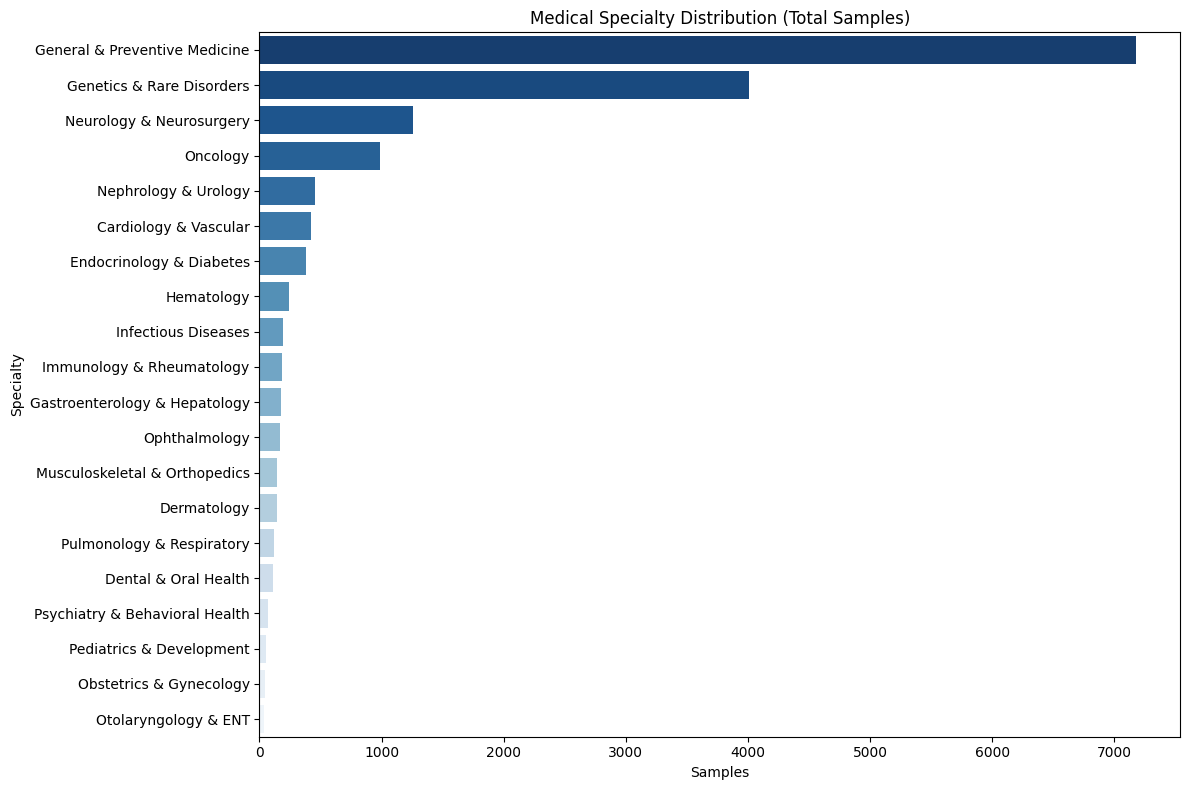

In [9]:
specialty_counts = (
    catalog_assignments
    .groupby("specialty")
    .agg(
        unique_focus_areas=("focus_area_norm", "count"),
        total_samples=("sample_count", "sum"),
        median_confidence=("specialty_score", "median")
    )
    .sort_values("total_samples", ascending=False)
)

display(specialty_counts)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=specialty_counts.reset_index(),
    y="specialty",
    x="total_samples",
    palette="Blues_r"
)
plt.xlabel("Samples")
plt.ylabel("Specialty")
plt.title("Medical Specialty Distribution (Total Samples)")
plt.tight_layout()
plt.show()


## 💾 Save Artifacts

Export the catalog mapping, labeled dataset, per-specialty summary, and metadata for downstream notebooks.


In [10]:
df_final = df.merge(
    catalog_assignments[["focus_area_norm", "specialty", "specialty_score", "assignment_source"]],
    on="focus_area_norm",
    how="left",
    validate="many_to_one"
)

missing = df_final["specialty"].isna().sum()
if missing:
    print(f"⚠️ Filling {missing} rows with 'General & Preventive Medicine'.")
    df_final["specialty"] = df_final["specialty"].fillna("General & Preventive Medicine")
    df_final["assignment_source"] = df_final["assignment_source"].fillna("fallback_default")
    df_final["specialty_score"] = df_final["specialty_score"].fillna(0.0)

df_final.to_csv(ARTIFACTS_DIR / "medquad_with_specialties.csv", index=False)
catalog_assignments.to_csv(ARTIFACTS_DIR / "focus_area_specialty_mapping.csv", index=False)
specialty_counts.reset_index().to_csv(ARTIFACTS_DIR / "specialty_distribution.csv", index=False)

metadata = {
    "generated_at": datetime.utcnow().isoformat() + "Z",
    "input_path": str(INPUT_PATH),
    "n_rows": int(len(df_final)),
    "n_unique_focus_areas": int(len(catalog_assignments)),
    "n_specialties": int(specialty_counts.shape[0]),
    "low_confidence_threshold": LOW_CONFIDENCE_THRESHOLD,
    "override_rules": [pattern.pattern for pattern, _ in OVERRIDE_RULES],
    "fallback_rules": [pattern.pattern for pattern, _ in FALLBACK_RULES],
    "specialty_order": SPECIALTY_ORDER,
}

with open(ARTIFACTS_DIR / "taxonomy_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("✅ Saved artifacts:")
for filename in [
    "medquad_with_specialties.csv",
    "focus_area_specialty_mapping.csv",
    "specialty_distribution.csv",
    "taxonomy_metadata.json",
]:
    print(f"   - {filename}")

df_final.head()


✅ Saved artifacts:
   - medquad_with_specialties.csv
   - focus_area_specialty_mapping.csv
   - specialty_distribution.csv
   - taxonomy_metadata.json


,question,answer,source,focus_area,focus_area_norm,focus_area_simple,specialty,specialty_score,assignment_source
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,glaucoma,glaucoma,Ophthalmology,1.0,regex_override
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma,glaucoma,glaucoma,Ophthalmology,1.0,regex_override
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma,glaucoma,glaucoma,Ophthalmology,1.0,regex_override
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma,glaucoma,glaucoma,Ophthalmology,1.0,regex_override
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,glaucoma,glaucoma,Ophthalmology,1.0,regex_override


## ⚠️ Limitations & Notes

- **Not clinician-validated:** Rules were engineered for educational purposes. Always consult medical experts for production taxonomies.
- **Keyword dependence:** Rare conditions without matching anchors may still fall back to broader categories.
- **Overlap remains:** Some topics (e.g., endocrine ophthalmology) legitimately span multiple specialties. We record the runner-up label to support manual review.
- **Future work:** Incorporate specialist feedback, add semi-supervised fine-tuning, and evaluate downstream classifier performance with confusion matrices.


## 📌 Summary

- ✅ Rebuilt the specialty taxonomy using anchor-guided similarity, reinforcing clinical face validity.
- ✅ Added automated checks so canonical conditions map to their expected specialties.
- ✅ Exported refreshed artifacts for downstream notebooks.
- 🔁 Track `runner_up` labels for any manual refinement sessions.

**Next:** Proceed to `01_project_scope_and_data.ipynb` with the new `medquad_with_specialties.csv` labels.
